In [1]:
# import fiona
from shapely.geometry import *
from shapely.wkt import loads
# from shapely import LineString, MultiPoint
# from shapely.ops import nearest_points, split, snap, unary_union

import contextily as cx
# import earthaccess
import geopandas as gpd
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import xarray as xr
# import shapely

#### Functions

In [2]:
def readNHD(index):
    ## Set-up
    mdata_path = '/nas/cee-water/cjgleason/fiona/narrow_rivers_PIXC/data/'
# NEED WITH WATERBODY FOR CUSHMAN!!!!
    prep_path = '/nas/cee-water/cjgleason/fiona/narrow_rivers_PIXC_data/NHD_prepped/' # _with_waterbody

    # Define dtypes for lookup tables to preserve leading zeros
    dtype_dic= {'HUC4': str, 'HUC2': str, 'toBasin': str, 'level': str}
    # Read in HUC lookup table
    lookup = pd.read_csv(os.path.join(mdata_path, 'HUC4_lookup_no_great_lakes.csv'), dtype=dtype_dic)

    # Get current HUC2 and HUC4 IDs
    hu2 = 'HUC2_' + lookup.loc[index,'HUC4'][0:2]
    hu4 = 'NHDPLUS_H_' + lookup.loc[index,'HUC4'] + '_HU4_GDB'
    
    # Set data filepath
# NEED WITH WATERBODY FOR CUSHMAN!!!!!
    file_path = os.path.join(prep_path, hu2, hu4 + '_prepped.gpkg') # _with_waterbody

    ## Read in prepped NHD flowlines
    features = ['NHDPlusID', 'GNIS_Name', 'LengthKM', 'WidthM', 'Bin', 'geometry']
    basin = gpd.read_file(filename=file_path, columns=features, engine='pyogrio')

    # Drop reaches that are shorter than their width
    basin = basin[basin['LengthKM']*1000 > basin['WidthM']]
    
    # Make geometry 2D LineStrings
    basin['geometry'] = basin.geometry.explode().force_2d()
    return basin

In [ ]:
def cut(line, distance):
# Cuts a line in two at a distance from its starting point
# Returns the trimmed piece and the remainder of the linestring
    if distance <= 0.0 or distance >= line.length:
        return [LineString(line)]
    coords = list(line.coords)
    for i, p in enumerate(coords):
        pd = line.project(Point(p))
        if pd == distance:
            return [
                LineString(coords[:i+1]),
                LineString(coords[i:])]
        if pd > distance:
            cp = line.interpolate(distance)
            return [
                LineString(coords[:i] + [(cp.x, cp.y)]),
                LineString([(cp.x, cp.y)] + coords[i:])]

In [ ]:
def bitwiseMask(ds):
    # Fow now, eliminate the really bad stuff
    # See page 65 of PIXC PDD: https://podaac.jpl.nasa.gov/SWOT?tab=datasets-information&sections=about%2Bdata
    mask = np.where(np.logical_and(ds.classification > 1,
                                   ds.geolocation_qual 
                                   < 2**12
                                   # < 2**16
                                   ))[0]
    
    print(mask.shape)
    return mask

In [ ]:
def makeGDF(pixc):
    # This function takes the pixel cloud, makes a GeoDataFrame,
    # renames columns as needed, projects the CRS, and returns
    # the GDF 
    
    # Create GDF
    gdf_PIXC = gpd.GeoDataFrame(ds_PIXC.classification[mask],
                        geometry=gpd.points_from_xy(ds_PIXC.longitude[mask],
                                                    ds_PIXC.latitude[mask]),
                        crs="EPSG:4326") # PIXC has no native CRS, setting same as River_SP

    gdf_PIXC.rename(columns={gdf_PIXC.columns[0]: 'klass'}, inplace=True)
    
    # Convert the crs to WGS 84 / Pseudo-Mercator
    gdf_PIXC = gdf_PIXC.to_crs(epsg=3857)
    return gdf_PIXC

In [6]:
# def segmentReach(reach):
#     ### This is the loop version
    
#     # Get Geometry
#     gs = reach.geometry
#     # Extract line segment from GeoSeries
#     line = gs[reach.index[0]]
#     # print(line.length)
#     # Find length of segments
#     dist = line.length/10
#     # print(dist)
    
#     # Make empty list for segments
#     segments = []
    
# #     # Segment the reach
# #     for i in range(10):
# #         # Chop the reach, store remainder
# #         new, line = cut(line=line, distance=dist)

# #         # Append new segment to GeoSeries of all segments
# #         segments.append(new)

#     # Segment the reach
#     for i in range(9):
#         # Chop the reach, store remainder
#         new, line = cut(line=line, distance=dist)
#         # Append new segment to GeoSeries of all segments
#         segments.append(new)
    
#     # Append final segment to list
#     segments.append(line)
    
#     # Check the remainder to ensure we got the entire reach
#     # assert line.length < 1e-8
#     del new, line, dist
    
#     # Make dict for constructing new GeoDataFrame
#     d = {}
#     for i in range(reach.shape[1]):
#         d[reach.iloc[:,i].name] = reach.iloc[0,i]
#     # Rename geometry for full reach
#     d['geometry_full'] = d['geometry']
    
#     # Make GeoDataFrame with new reach segments
#     reach_cut = gpd.GeoDataFrame(data=d, index=range(len(segments)),
#                                  geometry=segments, crs=reach.crs)
    
#     return reach_cut

In [ ]:
def segmentReach(reach):
    ### This will be the apply() version!
    print(reach.shape)
    # # Get Geometry
    # gs = reach.geometry
    # Extract line segment from GeoSeries
    # line = gs[reach.index[0]]
    line = reach.geometry
    # print(line.length)
    # Find length of segments
    dist = line.length/10
    # print(dist)
    
    # Make empty list for segments
    segments = []
    
#     # Segment the reach
#     for i in range(10):
#         # Chop the reach, store remainder
#         new, line = cut(line=line, distance=dist)

#         # Append new segment to GeoSeries of all segments
#         segments.append(new)

    # Segment the reach
    for i in range(9):
        # Chop the reach, store remainder
        new, line = cut(line=line, distance=dist)
        # Append new segment to GeoSeries of all segments
        segments.append(new)
    
    # Append final segment to list
    segments.append(line)
    
    # Check the remainder to ensure we got the entire reach
    # assert line.length < 1e-8
    del new, line, dist
    
    # Make dict for constructing new GeoDataFrame
    d = {}
    for i in range(reach.shape[0]):
        d[reach.iloc[i].name] = reach.iloc[i]
    # Rename geometry for full reach
    d['geometry_full'] = d['geometry']
    
    # Make GeoDataFrame with new reach segments
    reach_cut = gpd.GeoDataFrame(data=d, index=range(len(segments)),
                                 geometry=segments, crs=reach.crs)
    
    return reach_cut

In [74]:
def getCoverage(gdf_PIXC, reach_cut):
    ###
    
    # Buffer the reach segments by 1/2 the calculated width
    # CITE BEIGER
    reach_cut['geometry'] = reach_cut.geometry.buffer(distance=(reach_cut.WidthM/2)[0], cap_style='flat')
    
    
    # Get pixels in reach
    inside = gpd.sjoin(gdf_PIXC, reach_cut, how='inner', predicate='within').rename(columns={'index_right': 'segment'})

    if inside.empty:
        prop = 0
    else:    
        # Get number of pixels in each reach segment
        counts = pd.DataFrame(inside.segment.value_counts().reset_index().sort_index())
        # print(counts)
        # Calculate coverage
        prop = len(counts.loc[counts['count'] != 0])/10
        # print(prop)
    return prop

#### Read in and prep NHD

In [8]:
# Set slurm job index
i = 4 # HUC4 0108, Connecticut
# i = 109 # HUC4 1711, Snoqualmie

In [9]:
# Read prepped NHD
basin = readNHD(index=i)

#### Read in and prep PIXC

In [10]:
# pixc_path = '../data/small_rivers/mar_2024_ver_c/SWOT_L2_HR_PIXC_011_345_239R_20240227T044209_20240227T044220_PIC0_01.nc'
pixc_path = '../data/small_rivers/mar_2024_ver_c/leaf_off/SWOT_L2_HR_PIXC_014_341_229R_20240429T152954_20240429T153005_PIC0_01.nc'

In [65]:
tile_name = pixc_path[-71:-3]

In [11]:
# Read in xarray
ds_PIXC = xr.open_mfdataset(paths=pixc_path, group='pixel_cloud', engine='h5netcdf')

In [13]:
# # Make dict for legend labels
# flags = ds_PIXC.classification.flag_meanings.split() # extract each flag meaning
# codes = {idx:k for idx, k in enumerate(flags, start=1)}

In [14]:
counts = pd.DataFrame(ds_PIXC.geolocation_qual).value_counts().sort_index()
counts

0       
0.0          362643
1.0           19510
2.0              75
3.0              12
4.0         5292836
5.0          719368
6.0            1111
7.0             437
4096.0          132
4097.0           13
4098.0            1
4100.0        44754
4101.0         6101
4102.0           24
4103.0            5
524288.0       3893
524289.0        357
524290.0          2
524292.0     149645
524293.0       6670
524294.0        317
524295.0         16
528384.0          3
528385.0          3
528388.0       1338
528389.0         80
528390.0          1
Name: count, dtype: int64

In [15]:
# Make mask
mask = bitwiseMask(ds_PIXC)

# # If dataframe not empty after filtering
# if mask.shape != (0,):
#     # Make PIXC
gdf_PIXC = makeGDF(pixc=ds_PIXC)
    # # Append to list
    # d.append(gdf_PIXC)

(1552029,)


#### Get bounds of PIXC and crop basin to it

In [16]:
# Get bounds of PIXC, construct polygon
bounds_PIXC = gdf_PIXC.total_bounds
poly = box(bounds_PIXC[0], bounds_PIXC[1], bounds_PIXC[2], bounds_PIXC[3])

In [17]:
crop_basin = basin.clip(poly)

In [28]:
# Find width bins present in cropped hydrography
bins = list(np.unique(crop_basin.Bin))
bins

['(0, 10]',
 '(10, 20]',
 '(150, 200]',
 '(20, 30]',
 '(200, 500]',
 '(30, 40]',
 '(40, 50]',
 '(50, 60]',
 '(60, 70]']

In [21]:
# Order of all possible bins
order = ['(0, 10]', '(10, 20]', '(20, 30]', '(30, 40]', '(40, 50]',
         '(50, 60]', '(60, 70]', '(70, 80]', '(80, 90]', '(90, 100]',
         '(100, 150]', '(150, 200]']

In [33]:
# Make sorted list of bins present
ordered = []
for binn in order:
    if binn in bins:
        ordered.append(binn)

In [32]:
# crop_basin.plot()

#### Segment reach, calculates coverage functions

In [86]:
# # Initialize lists
# coverage = {}

# for binn in ordered:
#     reach = crop_basin.loc[crop_basin['Bin'] == binn].sample(n=1)
#     # '{}'.format(reach.NHDPlusID)
#     # # break
#     # reach_bins.append(reach.iloc[0,0])
    
#     # Get reach segments
#     reach_cut = segmentReach(reach)
    
#     # Get coverage for reach
#     prop = getCoverage(gdf_PIXC, reach_cut)
    
#     coverage[binn] = prop*100

In [ ]:
t = crop_basin.iloc[0,:]
t

Bin                                                    (0, 10]
GNIS_Name                                                 None
LengthKM                                                  0.39
NHDPlusID                                     10000900013415.0
WidthM                                                1.783037
geometry     LINESTRING (-8114805.784991784 5153293.1137269...
Name: 10117, dtype: object

In [ ]:
# Get Geometry
gs = gpd.GeoSeries(t['geometry'])

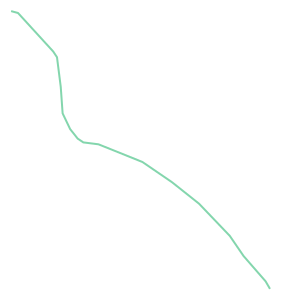

In [112]:
gs.geoemetry

In [ ]:
# Extract line segment from GeoSeries
line = gs[t.index[0]]

KeyError: 'Bin'

In [92]:
# Try with apply()
reach_cut = crop_basin.apply(segmentReach, axis=1)

(6,)


AttributeError: 'str' object has no attribute 'name'

In [84]:
coverage

{'(0, 10]': 10.0,
 '(10, 20]': 0,
 '(20, 30]': 0,
 '(30, 40]': 90.0,
 '(40, 50]': 0,
 '(50, 60]': 0,
 '(60, 70]': 100.0,
 '(150, 200]': 100.0}

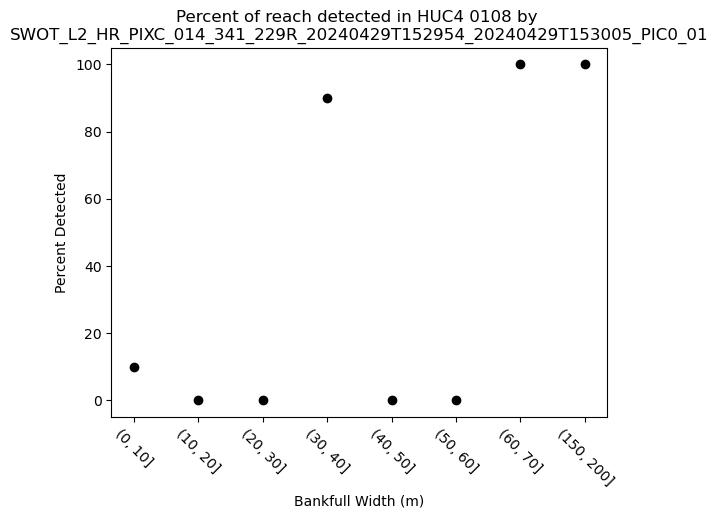

In [85]:
# plt.scatter(x=ordered, y=coverage, c='k')
plt.scatter(x=coverage.keys(), y=coverage.values(), c='k')
plt.title('Percent of reach detected in HUC4 0108 by \n'
          + tile_name)
plt.xticks(rotation=-45);
plt.xlabel('Bankfull Width (m)')
plt.ylabel('Percent Detected')
plt.savefig(fname='./figures_for_unit_test/one_tile_one_reach_per_bin.png', bbox_inches='tight')

#### TESTING

In [45]:
# Initialize lists
coverage = []
reach_bins = []

In [333]:
binn = bins[8]
binn

'(60, 70]'

In [334]:
reach = crop_basin.loc[crop_basin['Bin'] == binn].sample(n=1)

In [335]:
reach

,Bin,GNIS_Name,LengthKM,NHDPlusID,WidthM,geometry
55059,"(60, 70]",Chicopee River,1.635,1.000090e+13,68.029453,"LINESTRING (-8063447.795 5184435.381, -8063593..."


In [ ]:
reach.plot()

In [ ]:
reach_bins.append(reach.iloc[0,0])

In [ ]:
reach_bins

In [ ]:
# Convert MultiLineString Z to LineString (returns GeoSeries)
gs = reach.geometry
gs.plot()

In [ ]:
# Extract line segment from GeoSeries
line = gs[reach.index[0]]
line

In [ ]:
print(line.length)

In [ ]:
# Find length of segments
dist = line.length/10
print(dist)

In [ ]:
# Make empty list for segments
segments = []

In [ ]:
# Segment the reach
for i in range(9):
    # Chop the reach, store remainder
    new, line = cut(line=line, distance=dist)
    # Append new segment to GeoSeries of all segments
    segments.append(new)
    
segments.append(line)

In [ ]:
segments

In [ ]:
# Make dict for constructing new GeoDataFrame
d = {}
for i in range(reach.shape[1]):
    d[reach.iloc[:,i].name] = reach.iloc[0,i]
# Rename geometry for full reach
d['geometry_full'] = d['geometry']

# Make GeoDataFrame with new reach segments
reach_cut = gpd.GeoDataFrame(data=d, index=range(len(segments)),
                             geometry=segments, crs=reach.crs)

In [ ]:
reach_cut

In [ ]:
gpd.GeoSeries(segments).plot(cmap='hsv')

In [ ]:
reach_cut.plot(cmap='hsv')

In [ ]:
# Buffer the reach segments by 1/2 the calculated width
# CITE BEIGER
reach_cut['geometry'] = reach_cut.geometry.buffer(distance=(reach_cut.WidthM/2)[0], cap_style='flat')

In [ ]:
reach_cut.plot(cmap='hsv')

In [ ]:
# Get pixels in reach
inside = gpd.sjoin(gdf_PIXC, reach_cut, how='inner', predicate='within').rename(columns={'index_right': 'segment'})

In [ ]:
inside

In [ ]:
if inside.empty:
    coverage = 0
else:    
    # Get number of pixels in each reach segment
    counts = pd.DataFrame(inside.segment.value_counts().reset_index().sort_index())
    print(counts)
    # Calculate coverage
    coverage = len(counts.loc[counts['count'] != 0])/len(counts.segment)

In [ ]:
coverage